Importing the dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from prophet import Prophet
import datetime

Extracting Datasets

In [2]:
try:
    train_df = pd.read_csv('/content/train.csv')
    test_df = pd.read_csv('/content/test.csv')
    meal_info_df = pd.read_csv('/content/meal_info.csv')
    fulfilment_center_info_df = pd.read_csv('/content/fulfilment_center_info.csv')
    sample_submission_df = pd.read_csv('/content/sample_submission.csv')
    print("All datasets loaded successfully.")
except FileNotFoundError as e:
    print("Error loading file.")

All datasets loaded successfully.


Shape and Head of the datasets

In [3]:
print(f"Train Data Shape: {train_df.shape}")
print(f"Test Data Shape: {test_df.shape}")
print(f"Meal Info Data Shape: {meal_info_df.shape}")
print(f"Fulfilment Center Info Data Shape: {fulfilment_center_info_df.shape}")
print(f"Sample Submission Data Shape: {sample_submission_df.shape}")

print("\n--- Initial Data Overview ---")
print("\nTrain Data Head:")
print(train_df.head())
print("\nTest Data Head:")
print(test_df.head())
print("\nMeal Info Head:")
print(meal_info_df.head())
print("\nFulfilment Center Info Head:")
print(fulfilment_center_info_df.head())

Train Data Shape: (456548, 9)
Test Data Shape: (32573, 8)
Meal Info Data Shape: (51, 3)
Fulfilment Center Info Data Shape: (77, 5)
Sample Submission Data Shape: (32573, 2)

--- Initial Data Overview ---

Train Data Head:
        id  week  center_id  meal_id  checkout_price  base_price  \
0  1379560     1         55     1885          136.83      152.29   
1  1466964     1         55     1993          136.83      135.83   
2  1346989     1         55     2539          134.86      135.86   
3  1338232     1         55     2139          339.50      437.53   
4  1448490     1         55     2631          243.50      242.50   

   emailer_for_promotion  homepage_featured  num_orders  
0                      0                  0         177  
1                      0                  0         270  
2                      0                  0         189  
3                      0                  0          54  
4                      0                  0          40  

Test Data Head:
     

Merging the datasets

In [4]:
# Merge train_df with meal_info and fulfilment_center_info

df_train_merged = pd.merge(train_df, meal_info_df, on='meal_id', how='left')
df_train_merged = pd.merge(df_train_merged, fulfilment_center_info_df, on='center_id', how='left')

# Merge test_df with meal_info and fulfilment_center_info

df_test_merged_ids = test_df[['id']].copy() # Store original IDs for submission
df_test_merged = pd.merge(test_df, meal_info_df, on='meal_id', how='left')
df_test_merged = pd.merge(df_test_merged, fulfilment_center_info_df, on='center_id', how='left')

print("Datasets merged successfully.")

Datasets merged successfully.


In [5]:
# Check merged data info and missing values

print("\n--- Merged Train Data Info ---")
print(df_train_merged.info())

print("\nMissing values in Merged Train Data (before handling):")
print(df_train_merged.isnull().sum())

print("\nMerged Train Data Head:")
print(df_train_merged.head())

print("\n--- Merged Test Data Info ---")
print(df_test_merged.info())

print("\nMissing values in Merged Test Data (before handling):")
print(df_test_merged.isnull().sum())

print("\nMerged Test Data Head:")
print(df_test_merged.head())


--- Merged Train Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
 9   category               456548 non-null  object 
 10  cuisine                456548 non-null  object 
 11  city_code              456548 non-null  int64  
 12  region_code            456548 non-null  int64  
 13  center_type            456548 non-null  object 
 14  op_a

Initial Data Preprocessing

In [6]:
base_date = pd.to_datetime('2017-01-02')

df_train_merged['week'] = train_df['week'].copy()
df_test_merged['week'] = test_df['week'].copy()

# Calculate the actual date for each week number by adding (week_number - 1) weeks to the base date.
# df_train_merged['week'] is now guaranteed to be an integer series.
df_train_merged['week'] = base_date + pd.to_timedelta(df_train_merged['week'] - 1, unit='W')
df_test_merged['week'] = base_date + pd.to_timedelta(df_test_merged['week'] - 1, unit='W')

# Sort data by center, meal, and then week. This is essential for creating accurate lag features.
df_train_merged = df_train_merged.sort_values(by=['center_id', 'meal_id', 'week']).reset_index(drop=True)
df_test_merged = df_test_merged.sort_values(by=['center_id', 'meal_id', 'week']).reset_index(drop=True)

print("\nMerged Train Data Head after datetime conversion and sorting:")
print(df_train_merged.head())


Merged Train Data Head after datetime conversion and sorting:
        id       week  center_id  meal_id  checkout_price  base_price  \
0  1436842 2017-01-02         10     1062          181.39      181.39   
1  1205013 2017-01-09         10     1062          183.36      182.36   
2  1447751 2017-01-16         10     1062          184.36      182.36   
3  1014968 2017-01-23         10     1062          182.36      183.36   
4  1003563 2017-01-30         10     1062          183.39      181.39   

   emailer_for_promotion  homepage_featured  num_orders   category  cuisine  \
0                      0                  0         865  Beverages  Italian   
1                      0                  0         782  Beverages  Italian   
2                      0                  0         851  Beverages  Italian   
3                      0                  0        1202  Beverages  Italian   
4                      0                  0         958  Beverages  Italian   

   city_code  region_co

In [7]:
print(df_test_merged.head())

        id       week  center_id  meal_id  checkout_price  base_price  \
0  1177098 2019-10-14         10     1062          190.18      190.18   
1  1486011 2019-10-21         10     1062          193.03      194.03   
2  1301735 2019-10-28         10     1062          191.09      191.09   
3  1273097 2019-11-04         10     1062          189.15      189.15   
4  1450902 2019-11-11         10     1062          194.06      193.06   

   emailer_for_promotion  homepage_featured   category  cuisine  city_code  \
0                      0                  0  Beverages  Italian        590   
1                      0                  0  Beverages  Italian        590   
2                      0                  0  Beverages  Italian        590   
3                      0                  0  Beverages  Italian        590   
4                      0                  0  Beverages  Italian        590   

   region_code center_type  op_area  
0           56      TYPE_B      6.3  
1           56  

**Exploratory Data Analysis**

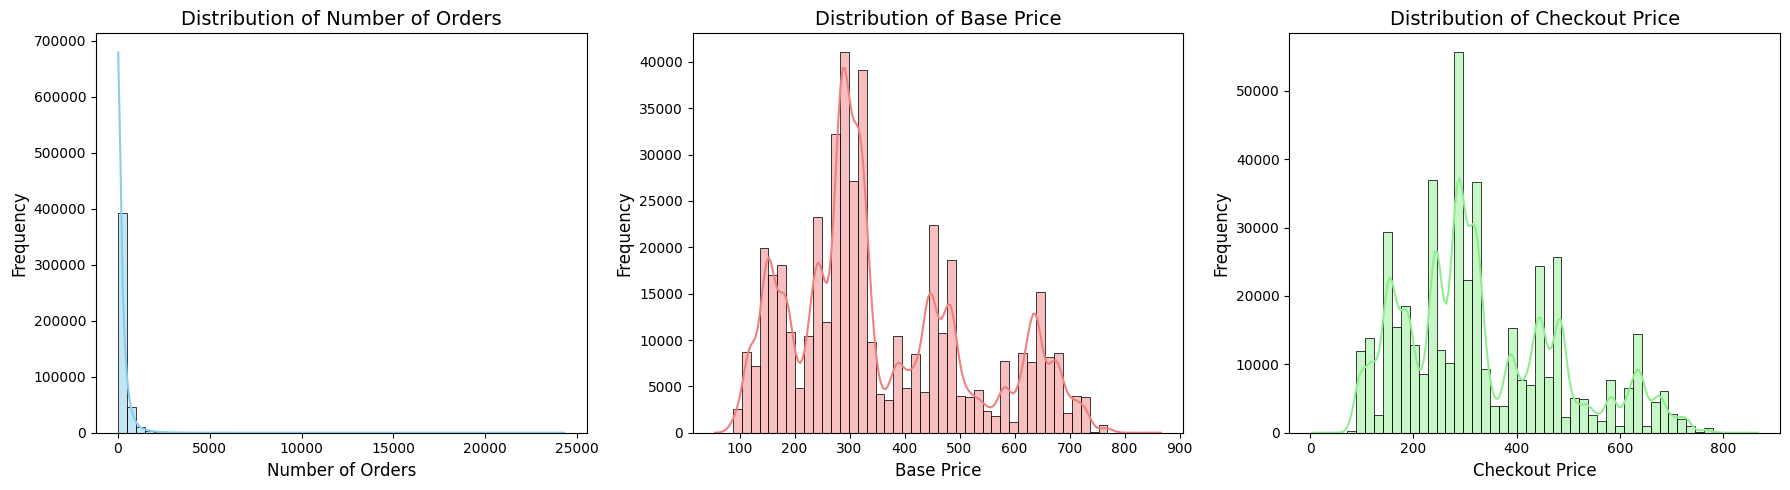

In [8]:
# Distribution of numerical features: `num_orders`, `base_price`, `checkout_price`

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.histplot(df_train_merged['num_orders'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Number of Orders', fontsize=14)
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(1, 3, 2)
sns.histplot(df_train_merged['base_price'], bins=50, kde=True, color='lightcoral')
plt.title('Distribution of Base Price', fontsize=14)
plt.xlabel('Base Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(1, 3, 3)
sns.histplot(df_train_merged['checkout_price'], bins=50, kde=True, color='lightgreen')
plt.title('Distribution of Checkout Price', fontsize=14)
plt.xlabel('Checkout Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

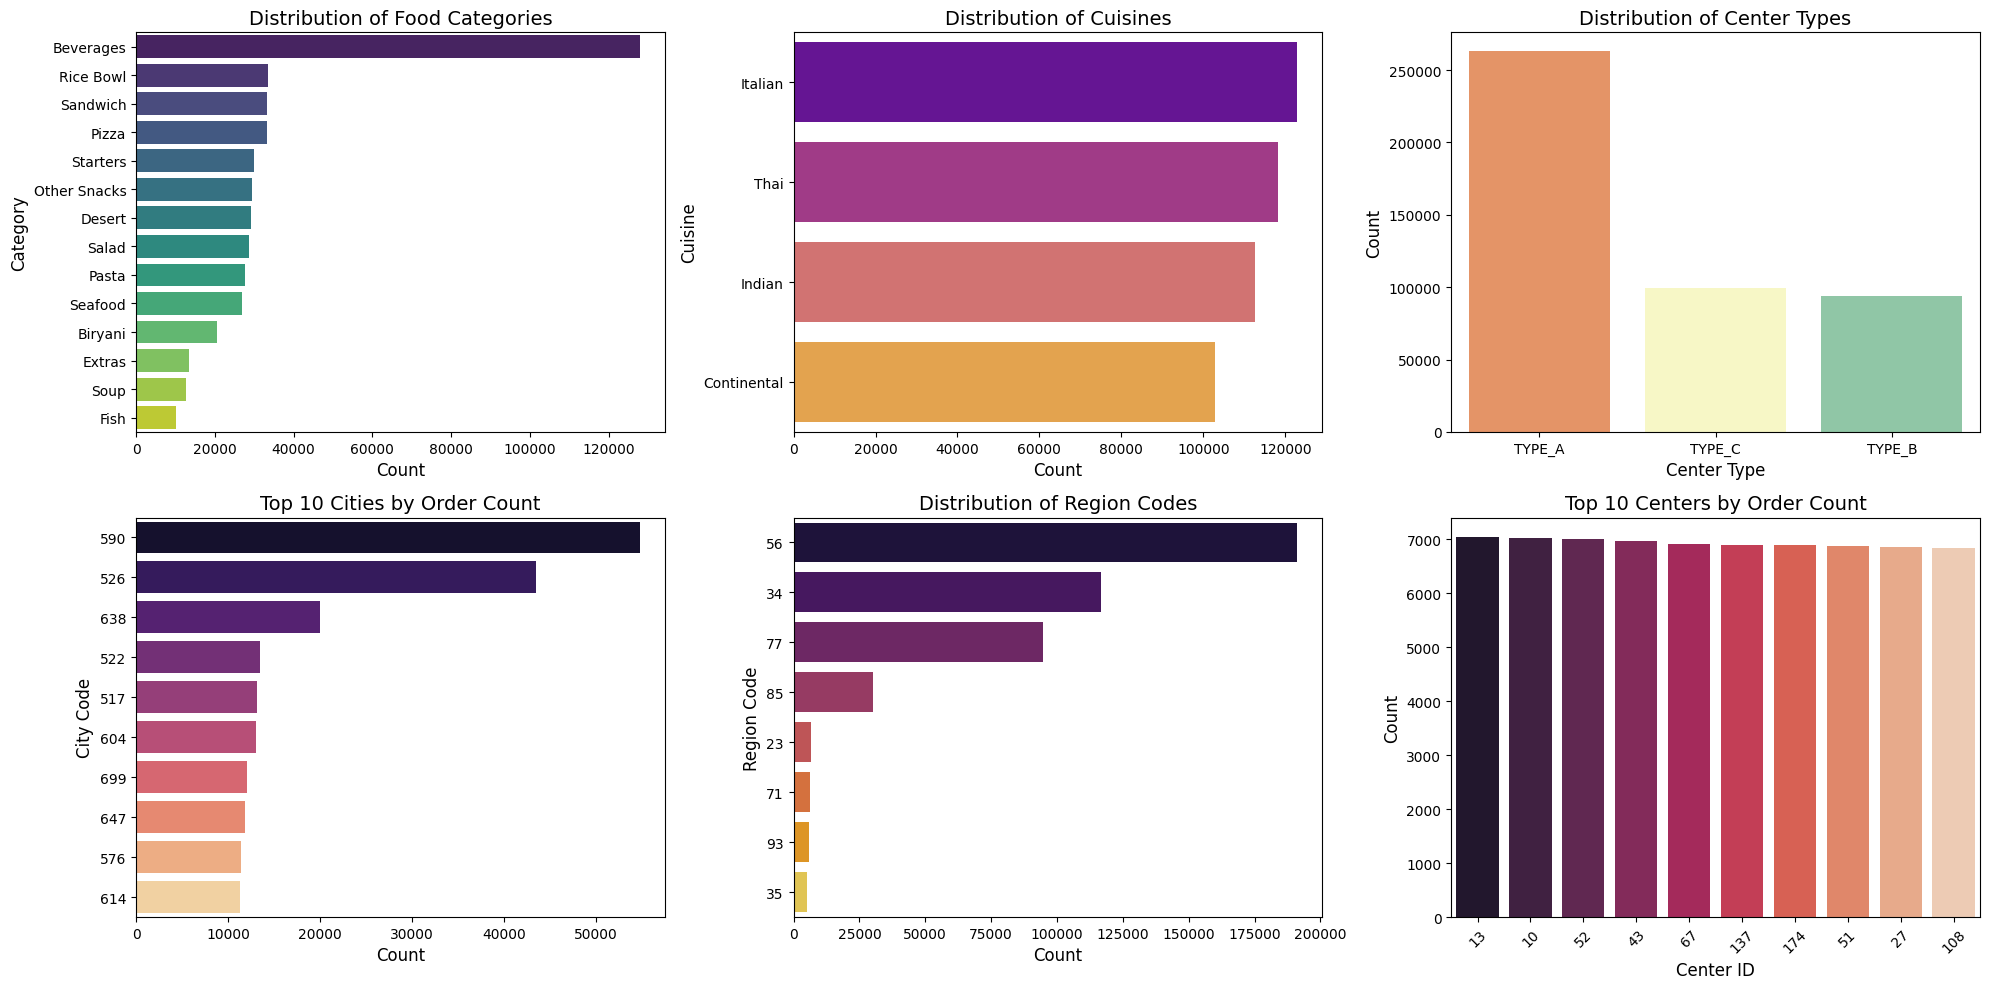

In [9]:
# Count plots for categorical features: `category`, `cuisine`, `center_type`, `city_code`, `region_code`

plt.figure(figsize=(20, 10))
plt.subplot(2, 3, 1)
sns.countplot(y='category', data=df_train_merged, order=df_train_merged['category'].value_counts().index, palette='viridis')
plt.title('Distribution of Food Categories', fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Category', fontsize=12)

plt.subplot(2, 3, 2)
sns.countplot(y='cuisine', data=df_train_merged, order=df_train_merged['cuisine'].value_counts().index, palette='plasma')
plt.title('Distribution of Cuisines', fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Cuisine', fontsize=12)

plt.subplot(2, 3, 3)
sns.countplot(x='center_type', data=df_train_merged, order=df_train_merged['center_type'].value_counts().index, palette='Spectral')
plt.title('Distribution of Center Types', fontsize=14)
plt.xlabel('Center Type', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot(2, 3, 4)
# Display top 10 city codes for readability
sns.countplot(y='city_code', data=df_train_merged, order=df_train_merged['city_code'].value_counts().index[:10], palette='magma')
plt.title('Top 10 Cities by Order Count', fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('City Code', fontsize=12)

plt.subplot(2, 3, 5)
sns.countplot(y='region_code', data=df_train_merged, order=df_train_merged['region_code'].value_counts().index, palette='inferno')
plt.title('Distribution of Region Codes', fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Region Code', fontsize=12)

plt.subplot(2, 3, 6)
# Display top 10 center IDs for readability
sns.countplot(x='center_id', data=df_train_merged, order=df_train_merged['center_id'].value_counts().index[:10], palette='rocket')
plt.title('Top 10 Centers by Order Count', fontsize=14)
plt.xlabel('Center ID', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

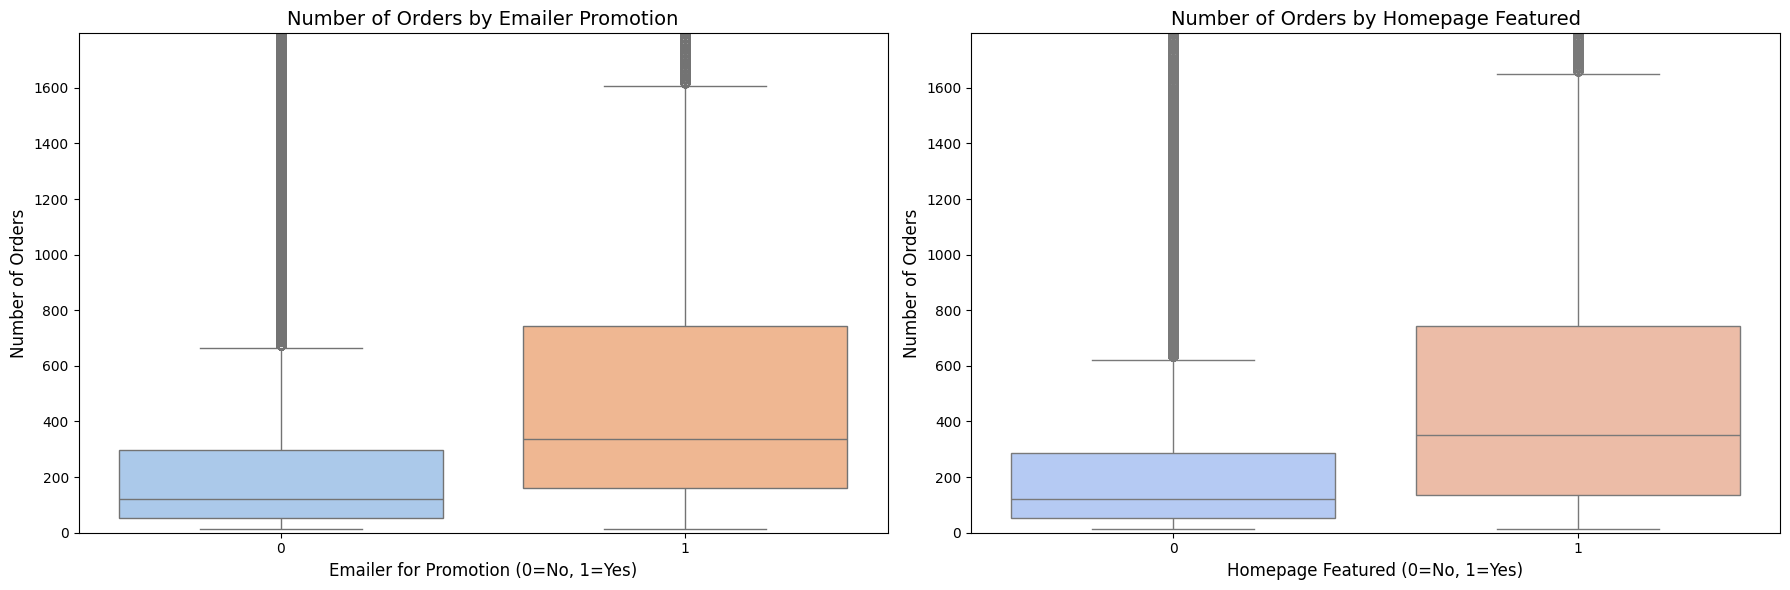

In [10]:
# Relationship between promotional features and `num_orders`

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='emailer_for_promotion', y='num_orders', data=df_train_merged, palette='pastel')
plt.title('Number of Orders by Emailer Promotion', fontsize=14)
plt.xlabel('Emailer for Promotion (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
# Capping y-axis to focus on the main distribution and reduce outlier impact on visualization
plt.ylim(0, df_train_merged['num_orders'].quantile(0.99))

plt.subplot(1, 2, 2)
sns.boxplot(x='homepage_featured', y='num_orders', data=df_train_merged, palette='coolwarm')
plt.title('Number of Orders by Homepage Featured', fontsize=14)
plt.xlabel('Homepage Featured (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
# Capping y-axis
plt.ylim(0, df_train_merged['num_orders'].quantile(0.99))
plt.tight_layout()
plt.show()

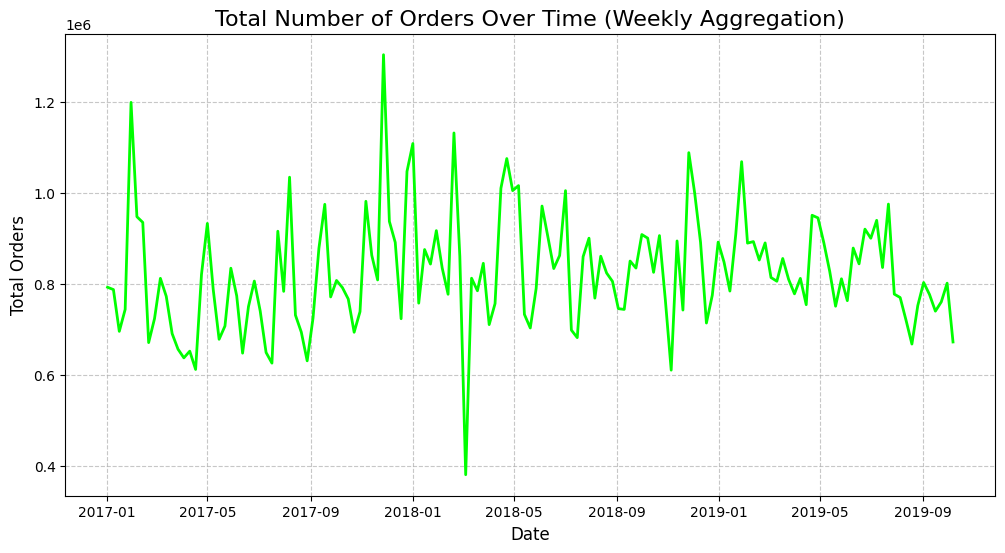

In [11]:
# Time series plot of total orders over time (aggregated weekly)

total_weekly_orders = df_train_merged.groupby('week')['num_orders'].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(total_weekly_orders['week'], total_weekly_orders['num_orders'], color='lime', linewidth=2)
plt.title('Total Number of Orders Over Time (Weekly Aggregation)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Orders', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


**Feature Engineering**

In [12]:
# Feature Engineering
# Create new features from existing ones to capture more complex relationships.

# Price difference
df_train_merged['price_diff'] = df_train_merged['base_price'] - df_train_merged['checkout_price']
df_test_merged['price_diff'] = df_test_merged['base_price'] - df_test_merged['checkout_price']

# Discount percentage
df_train_merged['discount_percentage'] = (df_train_merged['price_diff'] / df_train_merged['base_price']) * 100
df_test_merged['discount_percentage'] = (df_test_merged['price_diff'] / df_test_merged['base_price']) * 100

# Week-related features
df_train_merged['week_of_year'] = df_train_merged['week'].dt.isocalendar().week.astype(int)
df_train_merged['day_of_week'] = df_train_merged['week'].dt.dayofweek
df_train_merged['month'] = df_train_merged['week'].dt.month
df_train_merged['year'] = df_train_merged['week'].dt.year

df_test_merged['week_of_year'] = df_test_merged['week'].dt.isocalendar().week.astype(int)
df_test_merged['day_of_week'] = df_test_merged['week'].dt.dayofweek
df_test_merged['month'] = df_test_merged['week'].dt.month
df_test_merged['year'] = df_test_merged['week'].dt.year


df_train_merged['num_orders_lag1'] = df_train_merged.groupby(['center_id', 'meal_id'])['num_orders'].shift(1)
df_train_merged['num_orders_lag2'] = df_train_merged.groupby(['center_id', 'meal_id'])['num_orders'].shift(2)
df_train_merged['num_orders_lag3'] = df_train_merged.groupby(['center_id', 'meal_id'])['num_orders'].shift(3)


df_train_merged.fillna(0, inplace=True)
df_test_merged.fillna(0, inplace=True)

print("Train data after feature engineering:")
print(df_train_merged.head())
print("\nTest data after feature engineering:")
print(df_test_merged.head())

Train data after feature engineering:
        id       week  center_id  meal_id  checkout_price  base_price  \
0  1436842 2017-01-02         10     1062          181.39      181.39   
1  1205013 2017-01-09         10     1062          183.36      182.36   
2  1447751 2017-01-16         10     1062          184.36      182.36   
3  1014968 2017-01-23         10     1062          182.36      183.36   
4  1003563 2017-01-30         10     1062          183.39      181.39   

   emailer_for_promotion  homepage_featured  num_orders   category  ...  \
0                      0                  0         865  Beverages  ...   
1                      0                  0         782  Beverages  ...   
2                      0                  0         851  Beverages  ...   
3                      0                  0        1202  Beverages  ...   
4                      0                  0         958  Beverages  ...   

  op_area  price_diff  discount_percentage week_of_year  day_of_week  mo

**One Hot Encoding**

In [13]:
# Convert categorical features into dummy variables.

categorical_cols = ['center_id', 'meal_id', 'cuisine', 'center_type', 'category']

df_train_encoded = pd.get_dummies(df_train_merged, columns=categorical_cols, drop_first=True)
df_test_encoded = pd.get_dummies(df_test_merged, columns=categorical_cols, drop_first=True)

print("One-hot encoding completed.")
print("\nTrain data after one-hot encoding:")
print(df_train_encoded.head())
print("\nTest data after one-hot encoding:")
print(df_test_encoded.head())

One-hot encoding completed.

Train data after one-hot encoding:
        id       week  checkout_price  base_price  emailer_for_promotion  \
0  1436842 2017-01-02          181.39      181.39                      0   
1  1205013 2017-01-09          183.36      182.36                      0   
2  1447751 2017-01-16          184.36      182.36                      0   
3  1014968 2017-01-23          182.36      183.36                      0   
4  1003563 2017-01-30          183.39      181.39                      0   

   homepage_featured  num_orders  city_code  region_code  op_area  ...  \
0                  0         865        590           56      6.3  ...   
1                  0         782        590           56      6.3  ...   
2                  0         851        590           56      6.3  ...   
3                  0        1202        590           56      6.3  ...   
4                  0         958        590           56      6.3  ...   

   category_Fish  category_Other S

In [14]:
# This step ensures both dataframes have the same columns in the same order.

train_cols = set(df_train_encoded.columns)
test_cols = set(df_test_encoded.columns)

missing_in_test = list(train_cols - test_cols)
for col in missing_in_test:
    df_test_encoded[col] = 0 # Add missing columns to test set, fill with 0

missing_in_train = list(test_cols - train_cols)
for col in missing_in_train:
    df_train_encoded[col] = 0 # Add missing columns to train set, fill with 0

# Ensure the order of columns is the same for both train and test sets
df_test_encoded = df_test_encoded[df_train_encoded.columns]

print("\nColumns aligned for train and test datasets.")


Columns aligned for train and test datasets.


**Model Training and Prediction**

In [17]:
X = df_train_encoded.drop(['id', 'week', 'num_orders'], axis=1)
y = df_train_encoded['num_orders']

# Split training data for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

print("\nData split into training and validation sets.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


Data split into training and validation sets.
X_train shape: (365238, 160), y_train shape: (365238,)
X_val shape: (91310, 160), y_val shape: (91310,)


Random Forest Regressor Model

In [18]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_val)

XGBoost Regressor Model

In [19]:
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_val)

LightGBM Regressor Model

In [21]:
lgbm_model = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_val)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2227
[LightGBM] [Info] Number of data points in the train set: 365238, number of used features: 159
[LightGBM] [Info] Start training from score 262.019105


Evaluating the models

In [23]:
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")

evaluate_model("Random Forest", y_val, y_pred_rf)
evaluate_model("XGBoost", y_val, y_pred_xgb)
evaluate_model("LightGBM", y_val, y_pred_lgbm)


Random Forest - MAE: 74.24, RMSE: 26641.58, R²: 0.836
XGBoost - MAE: 74.38, RMSE: 24808.64, R²: 0.848
LightGBM - MAE: 75.34, RMSE: 25499.81, R²: 0.843


Visualize ACTUAL vs PREDICTED

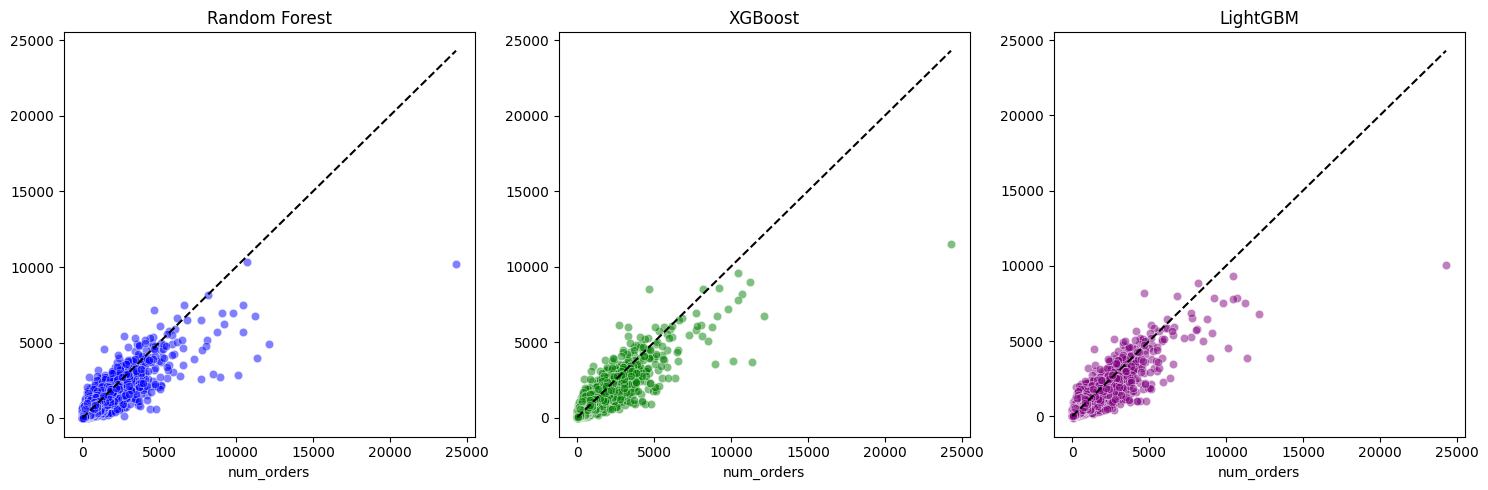

In [28]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(x=y_val, y=y_pred_rf, alpha=0.5, color='blue')
plt.title("Random Forest")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--')

plt.subplot(1, 3, 2)
sns.scatterplot(x=y_val, y=y_pred_xgb, alpha=0.5, color='green')
plt.title("XGBoost")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--')

plt.subplot(1, 3, 3)
sns.scatterplot(x=y_val, y=y_pred_lgbm, alpha=0.5, color='purple')
plt.title("LightGBM")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--')

plt.tight_layout()
plt.show()

Test Set Predictions and Export

In [27]:
X_test = df_test_merged.drop(columns=['id', 'center_id', 'meal_id'])
X_test = X_test.reindex(columns=X.columns, fill_value=0)
df_test_ids = df_test_merged[['id']].copy()

df_test_ids['num_orders'] = rf_model.predict(X_test)
df_test_ids.to_csv("submission_random_forest.csv", index=False)

df_test_ids['num_orders'] = xgb_model.predict(X_test)
df_test_ids.to_csv("submission_xgboost.csv", index=False)

df_test_ids['num_orders'] = lgbm_model.predict(X_test)
df_test_ids.to_csv("submission_lightgbm.csv", index=False)

print("Files are exported succesfully.")

Files are exported succesfully.
